# Coupled Eletric Device

Note: The example shown in this notebook is taken from the companion book [Nonlinear System Identification and Forecasting: Theory and Practice with SysIdentPy](https://sysidentpy.org/book/0-Preface/).

The CE8 coupled electric drives [dataset - Nonlinear Benchmark](https://www.nonlinearbenchmark.org/benchmarks) presents a compelling use case for demonstrating the performance of SysIdentPy. This system involves two electric motors driving a pulley with a flexible belt, creating a dynamic environment ideal for testing system identification tools.

> The [nonlinear benchmark website](https://www.nonlinearbenchmark.org/benchmarks) stands as a significant contribution to the system identification and machine learning community. The users are encouraged to explore all the papers referenced on the site.

### System Overview

The CE8 system, illustrated in Figure 1, features:
- **Two Electric Motors**: These motors independently control the tension and speed of the belt, providing symmetrical control around zero. This enables both clockwise and counterclockwise movements.
- **Pulley Mechanism**: The pulley is supported by a spring, introducing a lightly damped dynamic mode that adds complexity to the system.
- **Speed Control Focus**: The primary focus is on the speed control system. The pulley’s angular speed is measured using a pulse counter, which is insensitive to the direction of the velocity.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/ce8_design.png?raw=true)
> Figure 1. CE8 system design.

### Sensor and Filtering

The measurement process involves:
- **Pulse Counter**: This sensor measures the angular speed of the pulley without regard to the direction.
- **Analogue Low Pass Filtering**: This reduces high-frequency noise, followed by anti-aliasing filtering to prepare the signal for digital processing. The dynamic effects are mainly influenced by the electric drive time constants and the spring, with the low pass filtering having a minimal impact on the output.

### SOTA Results

SysIdentPy can be used to build robust models for identifying and modeling the complex dynamics of the CE8 system. The performance will be compared against a benchmark provided by [Max D. Champneys, Gerben I. Beintema, Roland Tóth, Maarten Schoukens, and Timothy J. Rogers - Baselines for Nonlinear Benchmarks, Workshop on Nonlinear System Identification Benchmarks, 2024.](https://arxiv.org/pdf/2405.10779)

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/ce8_sota.png?raw=true)

The benchmark evaluate the average metric between the two experiments. That's why the SOTA method do not have the better metric for `test 1`, but it is still the best overall.  The goal of this case study is not only to showcase the robustness of SysIdentPy but also provides valuable insights into its practical applications in real-world dynamic systems.

### Required Packages and Versions

To ensure that you can replicate this case study, it is essential to use specific versions of the required packages. Below is a list of the packages along with their respective versions needed for running the case studies effectively.

To install all the required packages, you can create a `requirements.txt` file with the following content:

```
sysidentpy==0.4.0
pandas==2.2.2
numpy==1.26.0
matplotlib==3.8.4
nonlinear_benchmarks==0.1.2
```

Then, install the packages using:
```
pip install -r requirements.txt
```

- Ensure that you use a virtual environment to avoid conflicts between package versions.
- Versions specified are based on compatibility with the code examples provided. If you are using different versions, some adjustments in the code might be necessary.

### SysIdentPy configuration

In this section, we will demonstrate the application of SysIdentPy to the CE8 coupled electric drives dataset. This example showcases the robust performance of SysIdentPy in modeling and identifying complex dynamic systems. The following code will guide you through the process of loading the dataset, configuring the SysIdentPy parameters, and building a model for CE8 system.

This practical example will help users understand how to effectively utilize SysIdentPy for their own system identification tasks, leveraging its advanced features to handle the complexities of real-world dynamic systems. Let's dive into the code and explore the capabilities of SysIdentPy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.utils.display_results import results
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_mean_squared_error
from sysidentpy.utils.plotting import plot_results

import nonlinear_benchmarks

train_val, test = nonlinear_benchmarks.CED(atleast_2d=True)
data_train_1, data_train_2 = train_val
data_test_1, data_test_2 = test

We used the `nonlinear_benchmarks` package to load the data. The user is referred to the package documentation [GerbenBeintema - nonlinear_benchmarks: The official dataload for nonlinear benchmark datasets](https://github.com/GerbenBeintema/nonlinear_benchmarks/tree/master) to check the details of how to use it.

The following plot detail the training and testing data of both experiments. Here we are trying to get two models, one for each experiment, that have a better performance than the mentioned baselines.

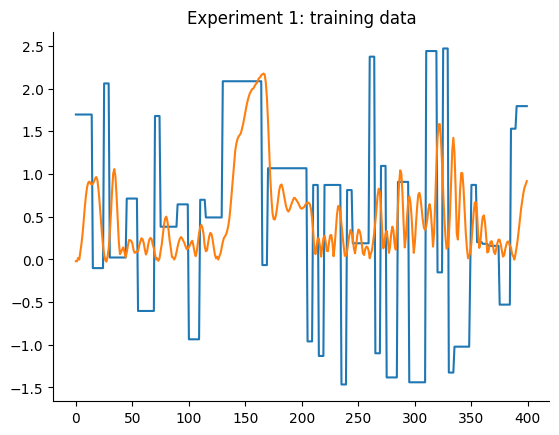

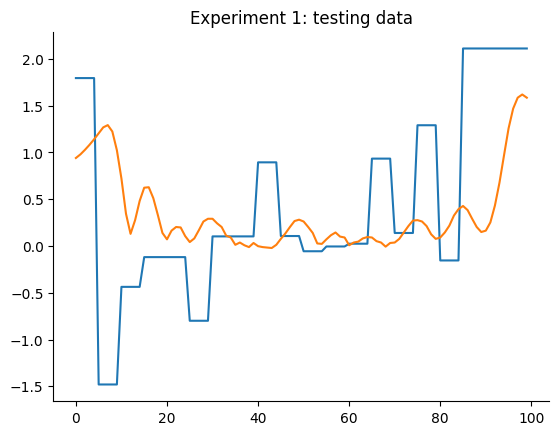

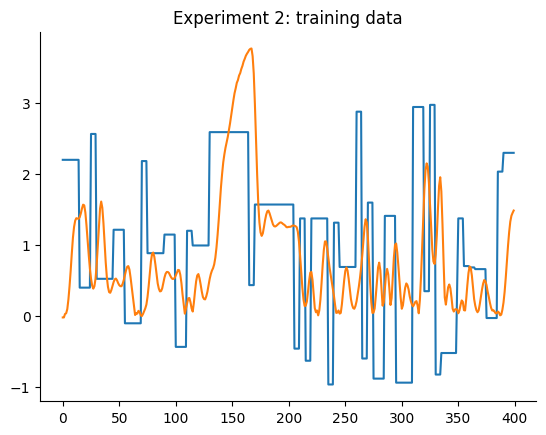

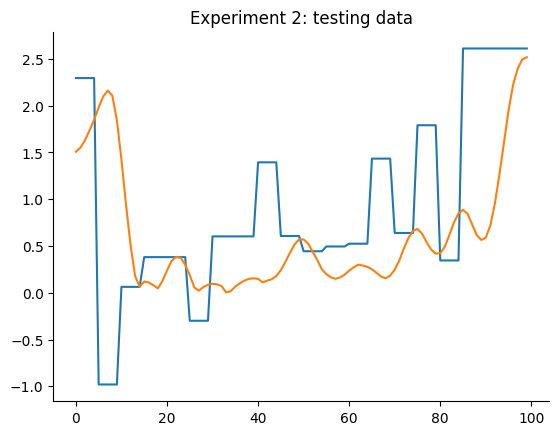

In [3]:
plt.plot(data_train_1.u)
plt.plot(data_train_1.y)
plt.title("Experiment 1: training data")
plt.show()

plt.plot(data_test_1.u)
plt.plot(data_test_1.y)
plt.title("Experiment 1: testing data")
plt.show()

plt.plot(data_train_2.u)
plt.plot(data_train_2.y)
plt.title("Experiment 2: training data")
plt.show()

plt.plot(data_test_2.u)
plt.plot(data_test_2.y)
plt.title("Experiment 2: testing data")
plt.show()

### Results

First, we will set the exactly same configuration to built models for both experiments. We can have better models by optimizing the configurations individually, but we will start simple.

A basic configuration of FROLS using a polynomial basis function with degree equal 2 is defined. The information criteria will be the default one, the `aic`. The `xlag` and `ylag` are set to $7$ in this first example.

Model for experiment 1:

c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\parameter_estimation\estimators.py:75: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


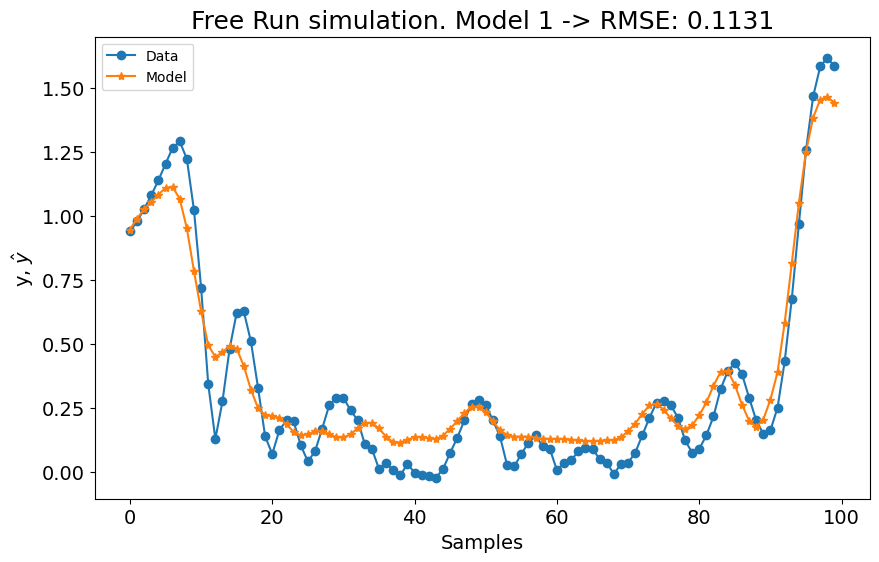

In [4]:
y_train = data_train_1.y
y_test = data_test_1.y
x_train = data_train_1.u
x_test = data_test_1.u

n = data_test_1.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=7,
    ylag=7,
    basis_function=basis_function,
    estimator=LeastSquares(),
    info_criteria="aic",
    n_info_values=120,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 1 -> RMSE: {round(rmse, 4)}",
)

Model for experiment 2:

c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\parameter_estimation\estimators.py:75: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


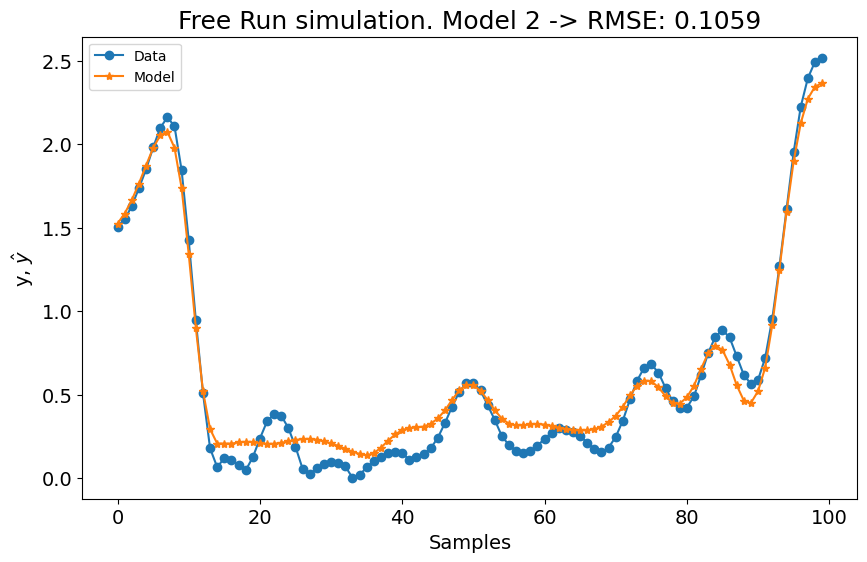

In [5]:
y_train = data_train_2.y
y_test = data_test_2.y
x_train = data_train_2.u
x_test = data_test_2.u

n = data_test_2.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=7,
    ylag=7,
    basis_function=basis_function,
    estimator=LeastSquares(),
    info_criteria="aic",
    n_info_values=120,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 2 -> RMSE: {round(rmse, 4)}",
)

The first configuration for experiment 1 is already better than the **LTI ARX**, **LTI SS**, **GRU**, **LSTM**, **MLP NARX**, **MLP FIR**, **OLSTM**, and the **SOTA** models shown in the benchmark table. Better than 8 out 11 models shown in the benchmark. For experiment 2, its better than **LTI ARX**, **LTI SS**, **GRU**, **RNN**, **LSTM**, **OLSTM**, and **pNARX** (7 out 11). It's a good start, but let's check if the performance improves if we set a higher lag for both `xlag` and `ylag`.

The average metric is $(0.1131 + 0.1059)/2 = 0.1095$, which is very good, but worse than the SOTA ($0.0945$). We will now increase the lags for `x` and `y` to check if we get a better model. Before increasing the lags, the information criteria is shown:

Text(0, 0.5, 'Information Criteria')

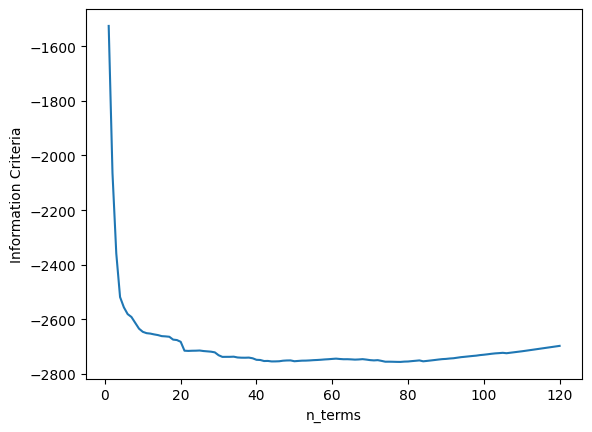

In [6]:
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")

It can be observed that after 22 regressors, adding new regressors do not improve the model performance (considering the configuration defined for that model). Because we want to try models with higher lags and higher nonlinearity degree, the stopping criteria will be changed to `err_tol` instead of information criteria. This will made the algorithm runs considerably faster.

(22, 2) 0.9970964868326048


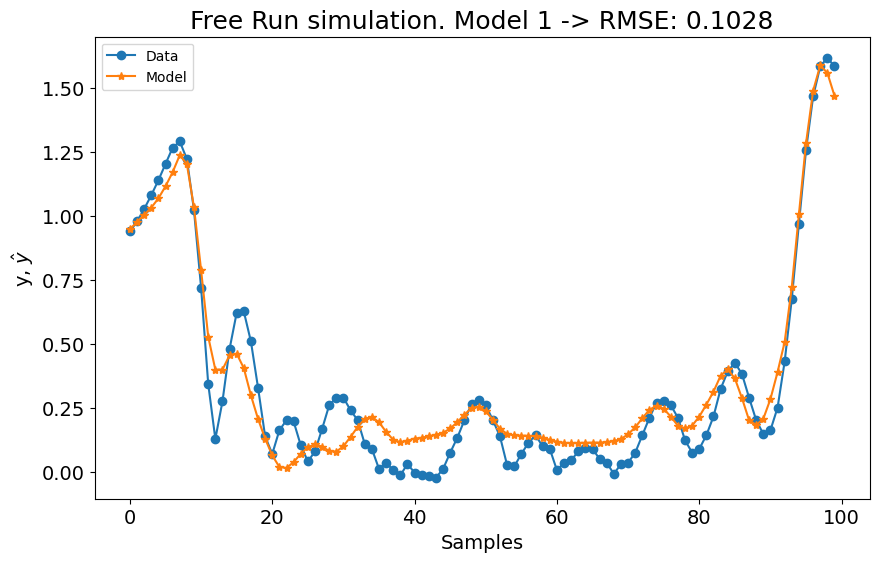

In [7]:
# experiment 1
y_train = data_train_1.y
y_test = data_test_1.y
x_train = data_train_1.u
x_test = data_test_1.u

n = data_test_1.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    err_tol=0.9996,
    n_terms=22,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
print(model.final_model.shape, model.err.sum())
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])

rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 1 -> RMSE: {round(rmse, 4)}",
)

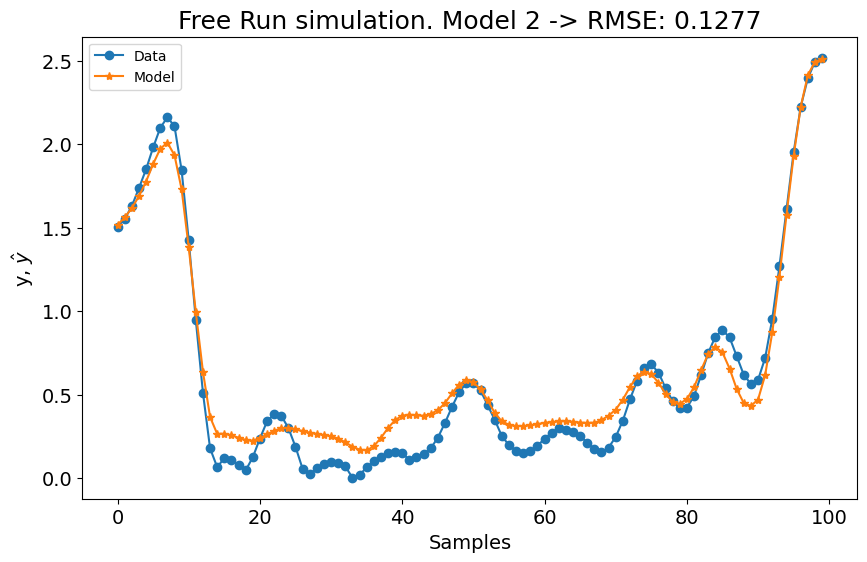

In [8]:
# experiment 2
y_train = data_train_2.y
y_test = data_test_2.y
x_train = data_train_2.u
x_test = data_test_2.u

n = data_test_2.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    info_criteria="aicc",
    err_tol=0.9996,
    n_terms=22,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])

rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 2 -> RMSE: {round(rmse, 4)}",
)

In the first experiment, the model showed a slight improvement, while the performance of the second experiment experienced a minor decline. Increasing the lag settings with these configurations did not result in significant changes. Therefore, let's set the polynomial degree to $3$ and increase the number of terms to build the model to `n_terms=40` if the `err_tol` is not reached. It's important to note that these values are chosen empirically. We could also adjust the parameter estimation technique, the `err_tol`, the model structure selection algorithm, and the basis function, among other factors. Users are encouraged to employ hyperparameter tuning techniques to find the optimal combinations of hyperparameters.

(40, 3) 0.9982136069197526


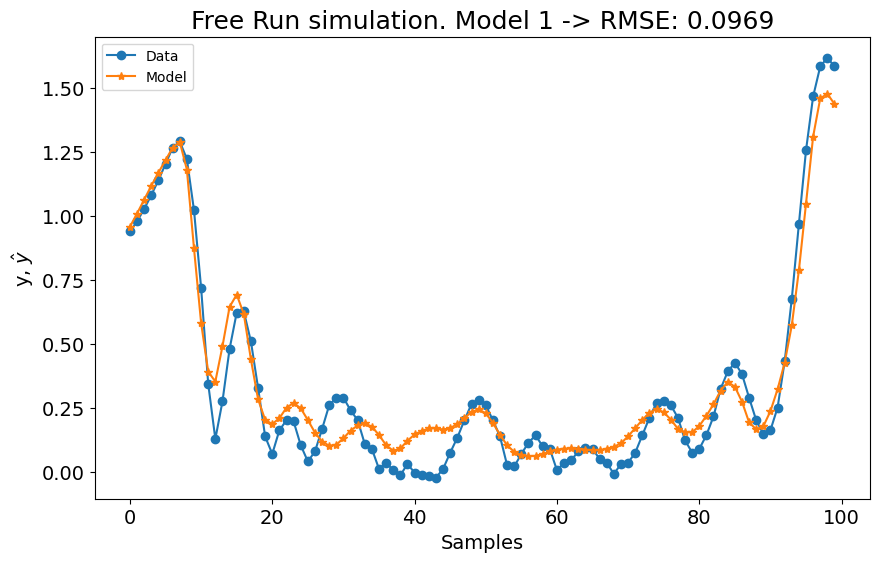

In [9]:
# experiment 1
y_train = data_train_1.y
y_test = data_test_1.y
x_train = data_train_1.u
x_test = data_test_1.u

n = data_test_1.state_initialization_window_length

basis_function = Polynomial(degree=3)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    err_tol=0.9996,
    n_terms=40,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
print(model.final_model.shape, model.err.sum())
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])

rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 1 -> RMSE: {round(rmse, 4)}",
)

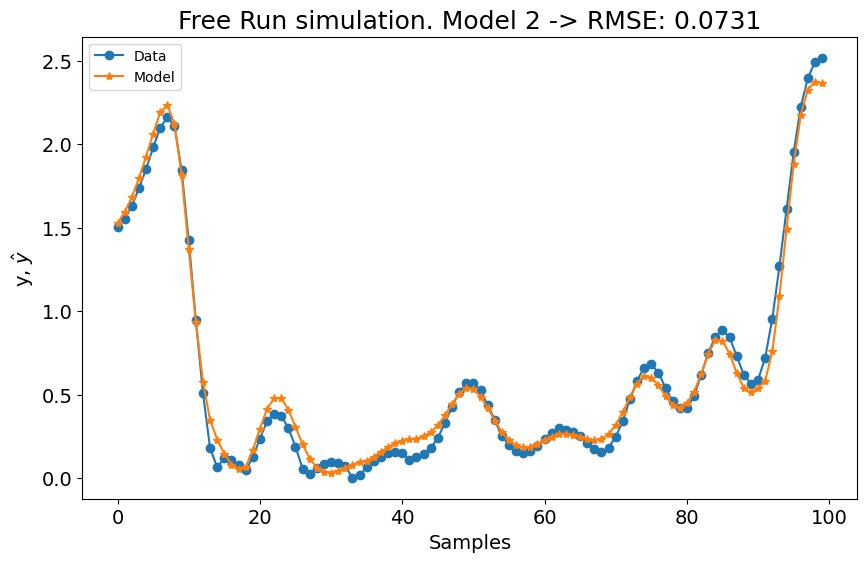

In [10]:
# experiment 2
y_train = data_train_2.y
y_test = data_test_2.y
x_train = data_train_2.u
x_test = data_test_2.u

n = data_test_2.state_initialization_window_length

basis_function = Polynomial(degree=3)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    info_criteria="aicc",
    err_tol=0.9996,
    n_terms=40,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])

rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=10000,
    title=f"Free Run simulation. Model 2 -> RMSE: {round(rmse, 4)}",
)

As shown in the plot, we have surpassed the state-of-the-art (SOTA) results with an average metric of $(0.0969 + 0.0731)/2 = 0.0849$. Additionally, the metric for the first experiment matches the best model in the benchmark, and the metric for the second experiment slightly exceeds the benchmark's best model. Using the same configuration for both models, we achieved the best overall results!